## Installing required Dependencies
### 1. Install Stable Baselines

For additional information, refer to: https://stable-baselines3.readthedocs.io/en/master/guide/install.html"

In [ ]:
!pip install stable-baselines3[extra]

## Import necessary Dependencies

In [1]:
import os
import gym
import random
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

from gym import Env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# Building An Environment

### Network Parameters:
1. Latency (MilliSeconds) (0 to 1500)  1 to 200ms
2. Available Bandwidth (Mbs 0 to 3k)   5k (for 5gbps)
3. Signal Strength (-10 dB to -120 dB) change to dBm 0dbm = -30 dB
4. Price per GB(INR) (2.5 to 10)

## Logging Changes For Visualization

In [2]:
app_latency_changes = []
app_bandwidth_changes = []

number_of_networks = 10
network_stats_latency = [[] for i in range(number_of_networks)]
network_stats_bandwidth = [[] for i in range(number_of_networks)]

best_network_latency = []
best_network_bandwidth = []

networkSelected = []

def resetLog():
    app_latency_changes = []
    app_bandwidth_changes = []

    number_of_networks = 10
    network_stats_latency = [[] for i in range(number_of_networks)]
    network_stats_bandwidth = [[] for i in range(number_of_networks)]

    best_network_latency = []
    best_network_bandwidth = []
    networkSelected = []
    
def logNetworkChanges(networks):
    for i in range(len(networks)):
        network_stats_latency[i].append(networks[i][0])
        network_stats_bandwidth[i].append(networks[i][1])        

def logAppChanges(network):
    app_latency_changes.append(network[0])
    app_bandwidth_changes.append(network[1])
    
def bestNetworkChanges(network):
    best_network_latency.append(network[0])
    best_network_bandwidth.append(network[1])

def logNetworkSelected(number):
    networkSelected.append(number)

In [3]:
def update_application_req(application_stats,rate_of_change):
    
    if random.uniform(0,1) < 1-rate_of_change:
        application_stats[0] = application_stats[0] + random.uniform(-30,30)
        if application_stats[0] > 1500:application_stats[0] = 1500
        elif application_stats[0] < 0: application_stats[0] = 10

        application_stats[1] = application_stats[1] + random.uniform(-100,100)
        if application_stats[1] > 3000: application_stats[1] = 3000
        elif application_stats[1] < 0: application_stats[1] = 10
        
    else:
        application_stats[0] = application_stats[0] + random.uniform(-400,400)
        if application_stats[0] > 1500: application_stats[0] = 1500
        elif application_stats[0] < 0: application_stats[0] = 10

        application_stats[1] = application_stats[1] + random.uniform(-1000,1000)
        if application_stats[1] > 3000: application_stats[1] = 3000
        elif application_stats[1] < 0: application_stats[1] = 10
# -------------------------------------------------------------------------------------
def network_value(network_stats,application_stats):
    delta_latency = application_stats[0] - network_stats[0]
    delta_bandwidth = network_stats[1] - application_stats[1]

    if delta_latency >= 0 and delta_bandwidth >= 0:
        efficiency = 1000000000/delta_latency*delta_bandwidth
    else:
        efficiency = -abs(delta_latency*delta_bandwidth)

    finalValue = 0.9*efficiency + 0.05*(120 - abs(network_stats[2])) + 0.05*network_stats[3]
    network_stats[4] = finalValue
    return finalValue
# -------------------------------------------------------------------------------------
class NetworkSelection(Env):
    def __init__(self,available_networks:int,rate_of_change:float):
        self.rate_of_change = 0.15
        self.cycle_length = 30 
        self.available_networks = available_networks
        self.action_space = Discrete(available_networks)
        self.previous_state = -1
        
        self.application_requirement = Box(low=np.array([0,0]),high=np.array([500,3000])).sample()
        self.network_stats = Box(low=np.array([0,0,-120,2.5,-99999]),high=np.array([1500,3000,-10,10,99999]))
        self.networks = [self.network_stats.sample() for i in range(self.available_networks)]
        
        
        self.state = [random.randint(-30,30) for i in range(self.available_networks)]
        low = np.array([[0,0,-120,2.5,-99999999999999999] for i in range(available_networks)])
        high = np.array([[1500,3000,-10,10,99999999999999999] for i in range(available_networks)])
        self.observation_space = Box(low=low,high=high)

        
        
    def step(self,action):
        self.cycle_length -= 1
        self.network_value = [network_value(i,self.application_requirement) for i in self.networks]
        
        logNetworkChanges(self.networks)
        bestNetworkChanges(self.networks[action])
        logAppChanges(self.application_requirement)
        logNetworkSelected(action)
        
        if np.argmax(self.network_value) == action:
            if action == self.previous_state:
                reward = 10
            else:
                reward = 8
        else:
            ranking = 0
            for value in self.network_value:
                if value > self.network_value[action]:
                    ranking += 1
            reward = ranking*-1
        
        if self.cycle_length <= 0:
            done = True
        else:
            done = False
        self.previous_state = action
        
        update_application_req(self.application_requirement,self.rate_of_change)
#         self.networks = [self.network_stats.sample() for i in range(self.available_networks)]
        info = {}

        return self.networks,reward,done,info

        
    def render(self):
        pass
    def reset(self):
        self.cycle_length = 30
        self.network_stats = Box(low=np.array([0,0,-120,2.5,-99999]),high=np.array([1500,3000,-10,10,99999]))
        self.networks = [self.network_stats.sample() for i in range(self.available_networks)]
        self.application_requirement = Box(low=np.array([0,0]),high=np.array([500,3000])).sample()
        return self.networks

## Model Testing on Random Input

In [4]:
# Model Performance on Random Input

episodes = 10
env = NetworkSelection(available_networks=10,rate_of_change=0.15)
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render() #set to PASS for now
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'Episode:{episode} Score:{score}')
env.close()

Episode:1 Score:-132
Episode:2 Score:-117
Episode:3 Score:-153
Episode:4 Score:-138
Episode:5 Score:-73
Episode:6 Score:-96
Episode:7 Score:-96
Episode:8 Score:-118
Episode:9 Score:-68
Episode:10 Score:-62


C:\Users\prath\anaconda3\envs\tf\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


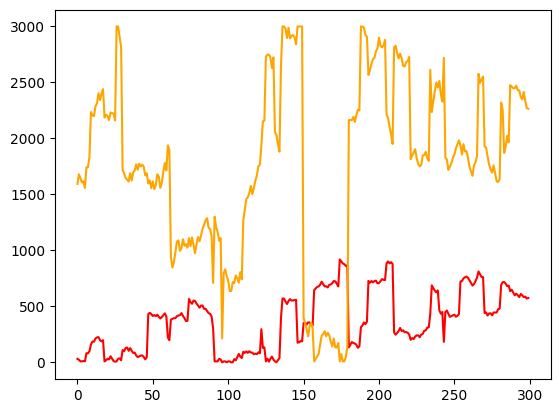

In [22]:
%matplotlib inline
# app_latency_changes
# app_bandwidth_changes

# number_of_networks = 10
# network_stats_latency
# network_stats_bandwidth

# best_network_latency
# best_network_bandwidth
# networkSelected
plt.plot(np.arange(0,len(app_latency_changes)),app_latency_changes,color='red')
plt.plot(np.arange(0,len(app_bandwidth_changes)),app_bandwidth_changes,color='orange')
plt.show()

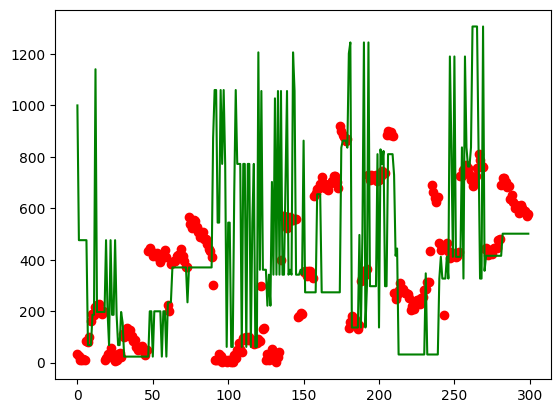

In [23]:
plt.scatter(np.arange(0,len(app_latency_changes)),app_latency_changes,color='red')
plt.plot(np.arange(0,len(best_network_latency)),best_network_latency,color='green')
plt.show()

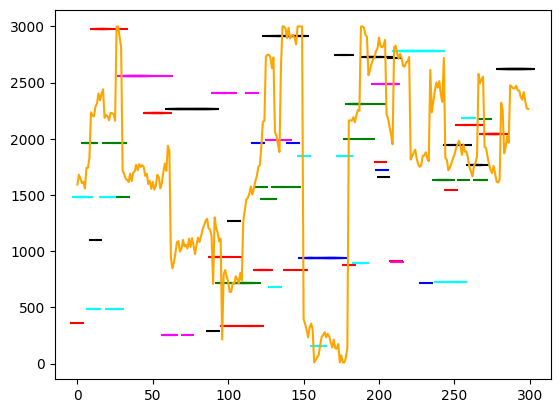

In [24]:
import matplotlib.colors as mcolors
cmap, norm = mcolors.from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10], ['cyan','red', 'green','magenta','black','blue','cyan','red', 'green','black'])
plt.plot(np.arange(0,len(app_bandwidth_changes)),app_bandwidth_changes,color='orange')
plt.scatter(np.arange(0,len(best_network_bandwidth)),best_network_bandwidth,marker="_",s=100,c=networkSelected, cmap=cmap, norm=norm)
plt.show()

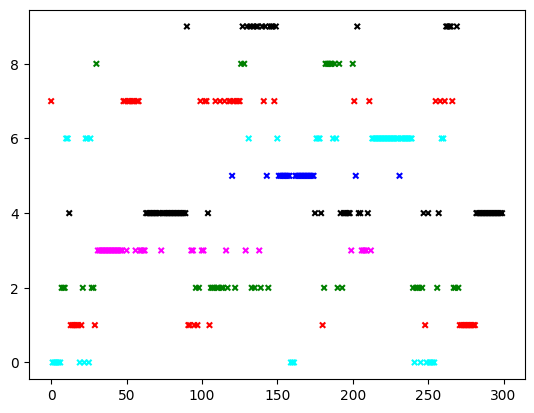

In [25]:
import matplotlib.colors as mcolors
cmap, norm = mcolors.from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10], ['cyan','red', 'green','magenta','black','blue','cyan','red', 'green','black'])
plt.scatter(np.arange(len(networkSelected)),networkSelected,s=15,c=networkSelected,marker='x',cmap=cmap, norm=norm)

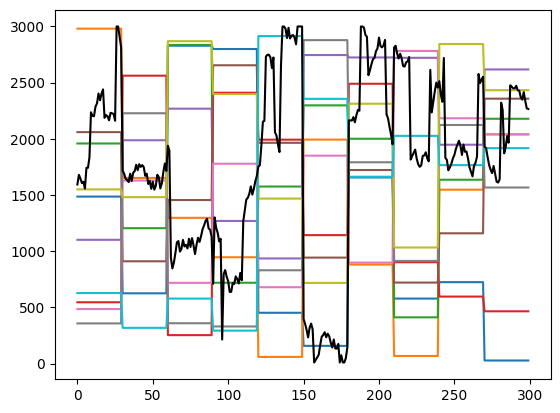

In [26]:
# number_of_networks = 10
# network_stats_latency
# network_stats_bandwidth

for i in range(number_of_networks):
    plt.plot(np.arange(len(network_stats_bandwidth[i])),network_stats_bandwidth[i])

plt.plot(app_bandwidth_changes,color='black')

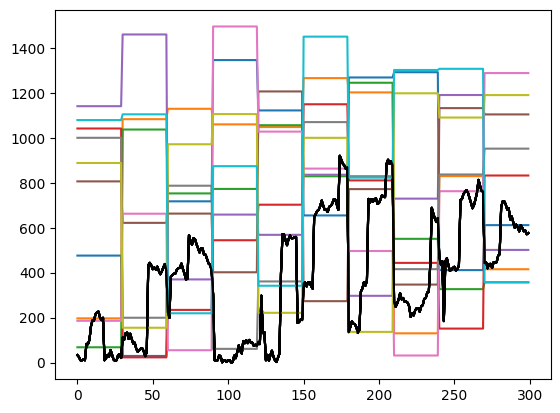

In [27]:
for i in range(number_of_networks):
    plt.plot(np.arange(len(network_stats_latency[i])),network_stats_latency[i])

    plt.plot(app_latency_changes,color='black')

## Training the Model

In [ ]:
log_path_ppo = os.path.join('Training','Logs','PPOZ')

In [ ]:
ppo_mlp_path = os.path.join('Training','SavedModels','PPOz1')

In [ ]:
model_ppo = PPO('MlpPolicy',env,verbose=1,tensorboard_log=log_path_ppo)

In [ ]:
# stop_callback = StopTrainingOnRewardThreshold(reward_threshold=100,verbose=1)
# eval_callback = EvalCallback(
#                             env,
#                             callback_on_new_best=stop_callback,
#                             eval_freq = 10000,
#                             best_model_save_path= ppo_mlp_path,
#                             verbose = 1
# )

model_ppo.learn(total_timesteps=120000)

## Save Model

In [ ]:
ppo_mlp_path = os.path.join('Training','SavedModels','PPOx3')
model_ppo.save(ppo_mlp_path)

In [ ]:
del model_ppo

In [13]:
ppo_mlp_path = os.path.join('Training','SavedModels','PPOX3')
model_ppo = PPO.load(ppo_mlp_path,env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
evaluate_policy(model_ppo,env,n_eval_episodes=200,render=False)

C:\Users\prath\anaconda3\envs\tf\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(109.84, 107.09222380733345)

In [21]:
# Model Performance after Training
app_latency_changes = []
app_bandwidth_changes = []

number_of_networks = 10
network_stats_latency = [[] for i in range(number_of_networks)]
network_stats_bandwidth = [[] for i in range(number_of_networks)]

best_network_latency = []
best_network_bandwidth = []

networkSelected = []

episodes = 10
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        env.render() #set to PASS for now
        action, _ = model_ppo.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'Episode:{episode} Score:{score}')
env.close()

Episode:1 Score:60
Episode:2 Score:226
Episode:3 Score:248
Episode:4 Score:-7
Episode:5 Score:-10
Episode:6 Score:207
Episode:7 Score:87
Episode:8 Score:247
Episode:9 Score:22
Episode:10 Score:271


## Viewing Logs in TensorBoard

In [11]:
print(f"Visit http://localhost:6006 for Statistics")

Visit http://localhost:6006 for Statistics


In [12]:
!tensorboard --logdir={os.path.join(log_path_ppo,'PPO_1')}

^C
